# Exploring generations

In [1]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import py3Dmol

# For highlight colors
from matplotlib.colors import ColorConverter

from ipywidgets import interact,fixed,IntSlider 


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:

    sys.path.append(module_path)
    
# Custom functions 
from my_utils.analysis import draw_generation,conf_viewer, sort_ga

#IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500,500
IPythonConsole.drawOptions.addAtomIndices = True

font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)


# The original structure as reference:  

In [2]:
Mo_hipt_path = '/home/magstr/Documents/nitrogenase/schrock/reference_structures/mo.xyz'
#draw_generation(Mo_hipt_path)

## PATHS: 

In [10]:
# Initilized path variables
templates = Path('../templates/')

# Path to folder with GA.pkl files
generation_path = Path('~').expanduser()/"generation_data/temp"

# What GA to look at 
gen  = 'GA67.pkl'

# How many molecules in the pop to look at 
size = 100

# Name of folder to put xyz files in 
xyz_files = generation_path / 'xyz_files'
Path(xyz_files).mkdir(exist_ok=True)

### The best ones from final generation

In [11]:
with open(generation_path/gen, "rb") as f:
    gen = pickle.load(f)

In [12]:
for i,elem in enumerate(gen.survivors.molecules[0:size]):

    with open(xyz_files/f'xtbopt{i}.xyz', "w+") as f:
        for line in elem.structure:
            f.write(line)

In [13]:
# Extract stuff from the generation

mols = []
list_idx = []
cut_idx = []
score = []

for elem in gen.survivors.molecules:
    mols.append(elem.rdkit_mol)    
    list_idx.append(elem.idx)
    score.append(elem.score)
    cut_idx.append([elem.cut_idx])
    

/home/magstr/miniconda3/envs/mols_test/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 9. Change the maxMols value to display more.
  % (maxMols))


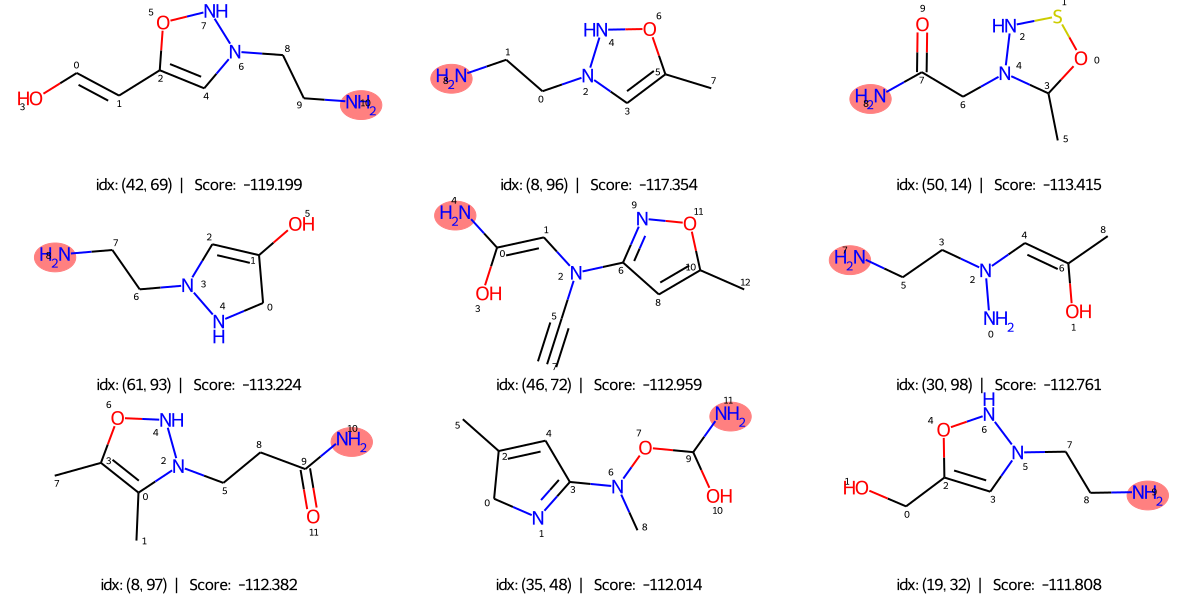

In [14]:
Draw.MolsToGridImage(mols,molsPerRow=3,maxMols=9,legends=[f'idx: {x}  |   Score:  {round(score,3)}' for x, score in zip(list_idx,score)], subImgSize=(400,200), highlightAtomLists=cut_idx,returnPNG=False)

In [15]:
paths = sorted(xyz_files.rglob('xtbopt*.xyz'))
len(paths)

100

In [16]:
interact(conf_viewer,confs=fixed(paths),idx=IntSlider(min=0,max=len(paths)-1,step=1), width=fixed(1200), height=fixed(500));

interactive(children=(IntSlider(value=0, description='idx', max=99), Output()), _dom_classes=('widget-interact…

### Energy evolution through time

In [17]:
# Get gen paths
gen_objects = sorted(generation_path.rglob('GA*.pkl'), key=sort_ga)

In [18]:
avg_energy=[]
for elem in gen_objects:
    with open(elem, "rb") as f:
        #f.seek(0)
        gen = pickle.load(f)
        
        df = gen.gen2pd()['score']
        pop_size = len(df)
        
        # Remove the 9999 energies from mean calc
        df = df[df < 1000]
        
        avg_energy.append(df.mean())

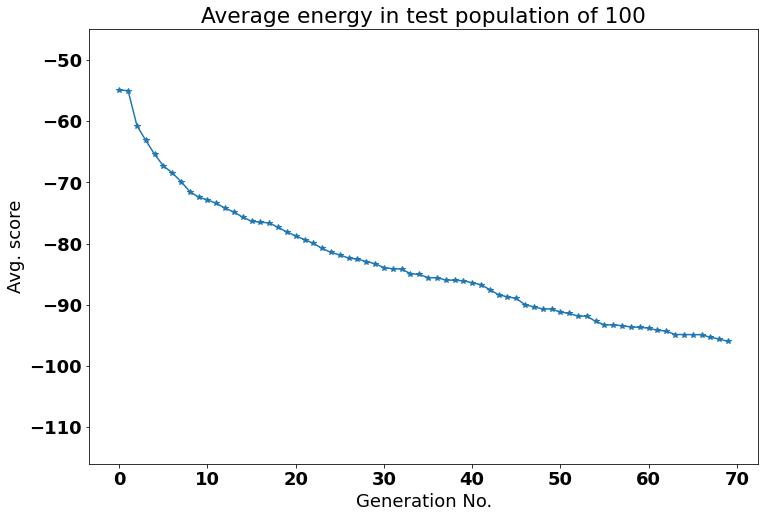

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(0,len(avg_energy))
ax.plot(x,avg_energy,'*-')
ax.set(xlabel='Generation No.', ylabel='Avg. score', title=f'Average energy in test population of {pop_size}', ylim =(min(avg_energy)-20,max(avg_energy)+10));
fig.savefig(generation_path/generation_path.stem, dpi=600)